# Factors Driving Austin Housing Prices 
Ricardo Dunia
<br/>
Kevin John Cherian Joseph
<br/>
Arnob Mallick

In [15]:
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from scipy import stats
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./data/austin_housing_data.csv')

## Lets look at avg increase in house value from 2015 to 2019 per Zip Code

In [3]:
df_appraisal_inc_zip = df.groupby('zip', as_index=False)['5-year Growth'].mean()

import folium
from folium import plugins

df_appraisal_inc_zip['zip'] = df_appraisal_inc_zip['zip'].astype(int).astype('str')
df_appraisal_inc_zip['5-year Growth'] = df_appraisal_inc_zip['5-year Growth'].astype(float)

district_geo = r'data/austin_area_zip_codes.geojson'
map_choro = folium.Map(location=[30.285516,-97.736753 ],tiles='OpenStreetMap', zoom_start=9)

choroplethMap = folium.Choropleth(
    geo_data=district_geo,
    name='choropleth',
    data=df_appraisal_inc_zip,
    columns=['zip', '5-year Growth'],
    key_on='properties.zipcode',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Percentage Growth Over 5 years by Zip Code').add_to(map_choro)

folium.LayerControl().add_to(map_choro)

map_choro.save('./reports/PercentageGrowthOver5yearsbyZipCode.html')
map_choro

## Zip Code Wise House Price Appreciations

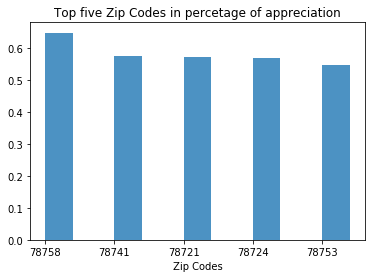

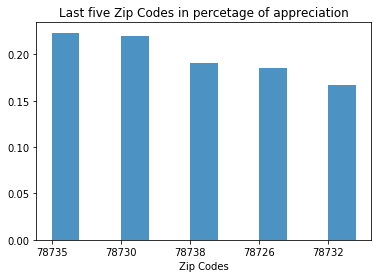

In [4]:
df_appraisal_inc_zip = df_appraisal_inc_zip.sort_values(by='5-year Growth',ascending=False)

df_top_zips = df_appraisal_inc_zip.head(5)
plt.bar(df_top_zips['zip'],df_top_zips['5-year Growth'], align='edge', alpha=0.8,width=0.4)
plt.xticks(df_top_zips['zip'])
plt.xlabel('Zip Codes')
plt.title('Top five Zip Codes in percetage of appreciation')

plt.show()

df_tail_zips = df_appraisal_inc_zip.tail(5)
plt.bar(df_tail_zips['zip'],df_tail_zips['5-year Growth'], align='edge', alpha=0.8,width=0.4)
plt.xticks(df_tail_zips['zip'])
plt.xlabel('Zip Codes')
plt.title('Last five Zip Codes in percetage of appreciation')

plt.show()

## Scale location sensitive data by Population Density

In [5]:
df['Crime Index Scaled'] = df['Crime Index'] / df['Population Density']
df['park_index_scaled'] = df['park_index'] / df['Population Density']
df['school_index_scaled'] = df['schools_index'] / df['Population Density']
df['event_index_scaled'] = df['event_index'] / df['Population Density']
df['fastfood_index_scaled'] = df['fastfood_index'] / df['Population Density']

In [6]:
df.describe()

,Unnamed: 0,daysOnMarket,hoa,latitude,longitude,lotSize,salePrice,pricePerSqFt,daysAftSold,sqFt,...,zip_78754,zip_78756,zip_78757,zip_78758,zip_78759,Crime Index Scaled,park_index_scaled,school_index_scaled,event_index_scaled,fastfood_index_scaled
count,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,2.438400e+04,24384.000000,24384.000000,24384.000000,...,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000
mean,40759.571891,2893.362164,18.437008,30.302651,-97.756544,9308.399278,3.130080e+05,161.580873,2900.362164,1982.975435,...,0.030635,0.025385,0.027928,0.026780,0.022433,49.021266,0.013374,0.012677,0.000602,0.014146
std,13850.949618,2205.981593,33.846092,0.086591,0.100770,7391.873708,2.071792e+05,89.377949,2205.981593,836.428433,...,0.172330,0.157296,0.164770,0.161443,0.148089,40.942693,0.008125,0.010714,0.001291,0.010443
min,2223.000000,2.000000,0.000000,30.100692,-98.015696,1189.000000,1.800000e+04,14.000000,9.000000,468.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30358.750000,965.000000,0.000000,30.235515,-97.836052,5793.000000,1.620000e+05,98.000000,972.000000,1346.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11.672669,0.006944,0.006775,0.000000,0.007023
50%,41794.500000,2396.000000,0.000000,30.308142,-97.739384,7535.000000,2.650000e+05,138.000000,2403.000000,1778.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,44.336461,0.012461,0.009159,0.000000,0.013514
75%,52611.250000,4563.750000,29.000000,30.368430,-97.689343,10062.000000,4.050000e+05,200.000000,4570.750000,2468.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,75.007187,0.018455,0.014136,0.000608,0.017441
max,61792.000000,8605.000000,600.000000,30.514585,-97.504938,65732.000000,2.340000e+06,619.000000,8612.000000,6000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,778.403427,0.090343,0.090343,0.007937,0.140187


## How does the cross-correlation matrix look?

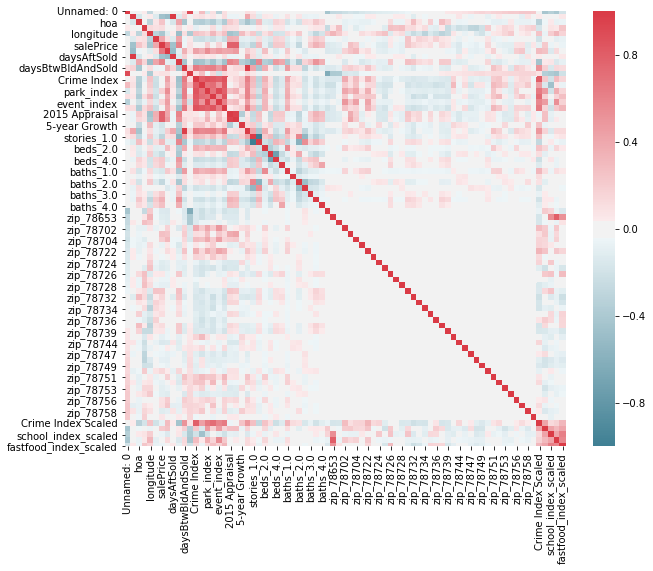

In [7]:
# examine the cross correlation matrix of the features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Try building a model to predict 5 Year Growth

In [61]:
# function for standardizing column names
def fix_column_names(df):
    cols = list(df)
    return df.rename(columns={ col: col.replace(' ', '_').lower() for col in cols })

# define a function that will train a model and output some stats 
def evaluate_model(df, prediction_col, with_zip):
    # adjust skewness of data
    df_temp = df.copy()
    numeric_feats = df_temp.dtypes[df_temp.dtypes != "object"].index
    numeric_feats = [ feat for feat in numeric_feats if 
        ('zip_' not in feat) and
        ('beds_' not in feat) and 
        ('baths_' not in feat) and 
        ('stories_' not in feat) ]
    skewed_feats = df_temp[numeric_feats].apply(lambda x: stats.skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    df_temp[skewed_feats] = np.log1p(df_temp[skewed_feats])
    df_temp = df_temp[~df_temp.isin([np.inf, -np.inf])]
    df_temp = df_temp.fillna(df_temp.mean())

    # isolate the data into the train and test set with input and output features
    excluded_feats = [
        'id', 'daysOnMarket', 'latitude', 'longitude', 'salePrice', 'daysAftSold', 'daysBtwBldAndSold',
        'Crime Index', 'idx', 'park_index', 'schools_index', 'event_index', 'fastfood_index', '2015 Appraisal',
        '2019 Appraisal', 'city', 'state', 'Number', 'Address', 'streetLine', 'zip' ]
    if not with_zip:
        excluded_feats = excluded_feats + [feat for feat in list(df_temp) if 'zip_' in feat]
    if prediction_col == '5-year Growth':
        excluded_feats = excluded_feats + ['5-year Growth']
    X = fix_column_names(df_temp.loc[:, [feat for feat in list(df_temp) if feat not in excluded_feats]])
    y = fix_column_names(df_temp.loc[:, [prediction_col]])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    regr = LinearRegression()
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # Calculate the Root Mean Squared Error
    rmse_regr = np.sqrt(mean_squared_error(y_test, regr_pred))
    print("RMSE: %f" % (rmse_regr))

    from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
    from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import RobustScaler

    #following a kaggle notebook - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

    lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    lasso_preds = lasso.fit(X_train, y_train).predict(X_test)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_preds))
    print("Lasso RSME: %f" % rmse_lasso)

    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    ENet_preds = ENet.fit(X_train, y_train).predict(X_test)
    rmse_ENet = np.sqrt(mean_squared_error(y_test, ENet_preds))
    print("ElasticNet RSME: %f" % rmse_ENet)

    # KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    # KRR_preds = KRR.fit(X_train, y_train).predict(X_test)
    # rmse_KRR = np.sqrt(mean_squared_error(y_test, KRR_preds))
    # print("KRR RSME: %f" % rmse_KRR)

    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                    max_depth=4, max_features='sqrt',
                                    min_samples_leaf=15, min_samples_split=10, 
                                    loss='huber', random_state =5)
    GBoost_preds = GBoost.fit(X_train, y_train).predict(X_test)
    rmse_GBoost = np.sqrt(mean_squared_error(y_test, GBoost_preds))
    print("GBoost RSME: %f" % rmse_GBoost)

    xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                learning_rate=0.05, max_depth=3, 
                                min_child_weight=1.7817, n_estimators=2200,
                                reg_alpha=0.4640, reg_lambda=0.8571,
                                subsample=0.5213, silent=1,
                                random_state =7, nthread = -1)
    xgb_preds = xgb_model.fit(X_train, y_train).predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
    print("XGB RSME: %f" % rmse_xgb)

    models = ('LinearRegression', 'Lasso', 'ElasticNet', 'GradientBoostingRegressor', 'XGBRegressor')
    y_pos = np.arange(len(models))
    performance = [rmse_regr,rmse_lasso,rmse_ENet,rmse_GBoost,rmse_xgb]
    coefs = [regr.coef_[0], lasso.steps[1][1].coef_[0], ENet.steps[1][1].coef_[0], [ ], [ ]]

    plt.barh(y_pos, performance, align='edge', alpha=0.8,height=0.4)
    plt.yticks(y_pos, models)
    plt.xlabel('RMSE')
    plt.title('Models')

    plt.show()

    return { 'models': models, 'perf': performance, 'data': X, 'coefs': coefs }

RMSE: 0.135952
Lasso RSME: 0.136807
ElasticNet RSME: 0.136636
GBoost RSME: 0.120320
XGB RSME: 0.121847


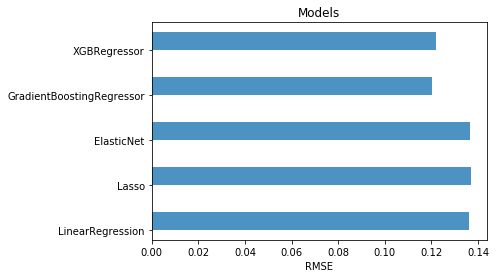

In [56]:
# build a model to predict 5-year Growth with zip codes included
result = evaluate_model(df, '5-year Growth', True)

## Try building the same model but without zip codes

RMSE: 0.142492
Lasso RSME: 0.142639
ElasticNet RSME: 0.142619
GBoost RSME: 0.120372
XGB RSME: 0.122116


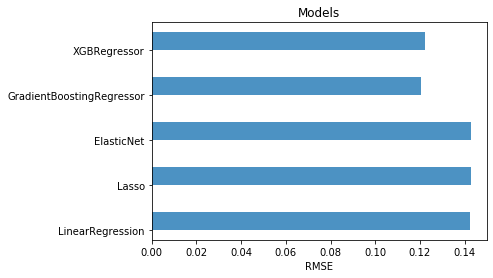

In [57]:
# build a model to predict 5-year Growth without zip codes included
result = evaluate_model(df, '5-year Growth', False)

## Try building a model to predict 2019 Appraisal

RMSE: 0.313955
Lasso RSME: 0.315006
ElasticNet RSME: 0.314819
GBoost RSME: 0.282193
XGB RSME: 0.279186


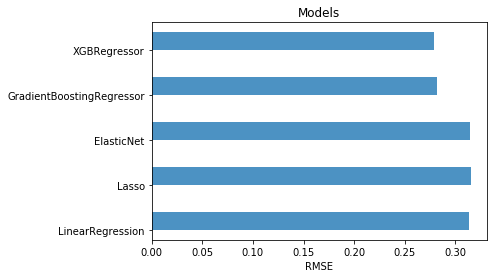

In [62]:
# build a model to predict 2019 Appraisal with zip codes included
result = evaluate_model(df, '2019 Appraisal', True)

## Try '2019 Appraisal' without zip codes this time

RMSE: 0.340951
Lasso RSME: 0.341238
ElasticNet RSME: 0.341204
GBoost RSME: 0.275420
XGB RSME: 0.283603


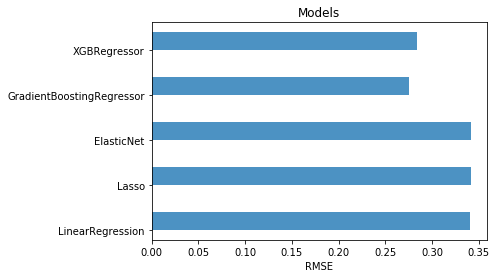

In [63]:
# build a model to predict 2019 Appraisal without zip codes included
result = evaluate_model(df, '2019 Appraisal', False)